# 3. Feature Engineering

## Read the data

In [1]:
!pip install imageio

In [2]:
# Import necessary library
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pathlib
import imageio
# Read the input csv


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
df_extra_processed = pd.read_csv('./converted_data/processed_extra.csv')
df_labels_processed = pd.read_csv('./converted_data/processed_label.csv')

In [4]:
df_extra_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10294 entries, 0 to 10293
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   instanceid   10294 non-null  int64 
 1   patientid    10294 non-null  int64 
 2   imagename    10294 non-null  object
 3   iscancerous  10294 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 321.8+ KB


In [5]:
df_labels_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9803 entries, 0 to 9802
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   instanceid    9803 non-null   int64 
 1   patientid     9803 non-null   int64 
 2   imagename     9803 non-null   object
 3   celltypename  9803 non-null   object
 4   celltype      9803 non-null   int64 
 5   iscancerous   9803 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 459.6+ KB


### 3/ Data processing

We need to determine if the celltypename is mapped with unique value in the celltype column

In [6]:
# Select the rows where the celltypename column is mapped to a value in the celltype column
df_mapped = df_labels_processed.loc[df_labels_processed['celltypename'].notnull(), ['celltypename', 'celltype']]

# Group the dataframe by the celltypename column and get the number of unique values in the celltype column for each group
num_unique = df_mapped.groupby('celltypename')['celltype'].nunique()

# Check if all values in the num_unique series are equal to 1
is_unique = num_unique.eq(1).all()
print(is_unique)

True


In [7]:
# Sort the dataframe by the celltype column
df_mapping = df_labels_processed.sort_values(by='celltype')

# Select the rows where the celltypename column is mapped to a value in the celltype column
df_mapping = df_mapping.loc[df_mapping['celltypename'].notnull(), ['celltypename', 'celltype']]

# Reset the index of the dataframe to start at 0
df_mapping = df_mapping.reset_index(drop=True)

In [8]:
# Determine the duplicates value
df_mapping.drop_duplicates()

,celltypename,celltype
0,fibroblast,0
1861,inflammatory,1
4366,epithelial,2
8429,others,3


### Correlation analysis

/var/folders/rv/7z1l4p8j1mq8sjr5hxfz73q00000gn/T/ipykernel_95827/1284710735.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_labels_corr = df_labels_processed.corr()


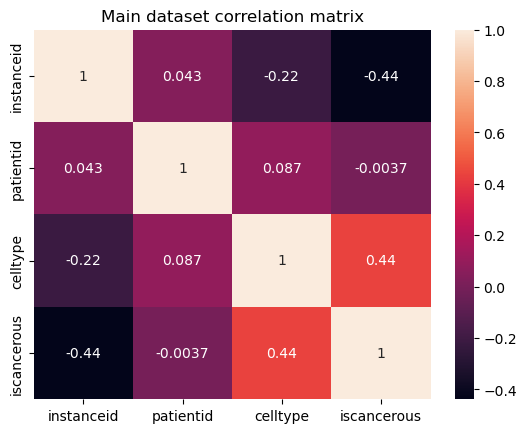

In [9]:
df_labels_corr = df_labels_processed.corr()
sns.heatmap(df_labels_corr, annot = True)
plt.title('Main dataset correlation matrix')
plt.show()

/var/folders/rv/7z1l4p8j1mq8sjr5hxfz73q00000gn/T/ipykernel_95827/670631090.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_extra_corr = df_extra_processed.corr()


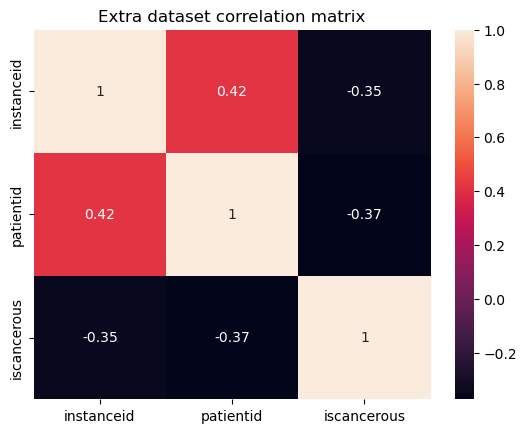

In [10]:
df_extra_corr = df_extra_processed.corr()
plt.title('Extra dataset correlation matrix')
sns.heatmap(df_extra_corr, annot = True)
plt.show()


#### Main dataset :
- As can be observe, the `celltype` and `instanceid` are correlated with `iscancerous` column.
#### Extra dataset :
- As can be observe, the `patienceid` are correlated with `instanceid`, `iscancerous` are slightly correlate with `instanceid` and `patienceid`

After conducting correlation analysis, due to the fact `patienceid` and `instanceid` only have contains unique identification number and does not correlated with the target column `iscancerous` (for both dataset) and `celltype` (only for main dataset), we are decided to drop them. 

After determine the mapped value, we can dropped `celltype` name in the `df_labels_processed` as well

In [11]:
drop_col_name = ['patientid','instanceid']
# Filter out
df_extra_dropped = df_extra_processed.drop(drop_col_name, axis = 1)
df_labels_dropped = df_labels_processed.drop(drop_col_name, axis = 1)
df_labels_dropped = df_labels_dropped.drop('celltypename',axis =1)

For this project we are conducting 2 task : Image classification for `iscancerous` column in 2 dataset, Image classification for `celltype` column.

The main dataset extra dataset both have `imagename` and `iscancerous` column therefore, we could merge them together 

In [12]:
df_concat = df_extra_dropped.append(df_labels_dropped[['imagename','iscancerous']], ignore_index=True)

/var/folders/rv/7z1l4p8j1mq8sjr5hxfz73q00000gn/T/ipykernel_95827/2235045679.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_concat = df_extra_dropped.append(df_labels_dropped[['imagename','iscancerous']], ignore_index=True)


In [13]:
df_concat = df_concat.drop_duplicates(subset='imagename', keep='last')

The final dataset we are going to use are `df_concat` for task 1 and `df_labels_dropped` for task 2

In [14]:
df_concat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20097 entries, 0 to 20096
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   imagename    20097 non-null  object
 1   iscancerous  20097 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 471.0+ KB


In [15]:
df_labels_dropped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9803 entries, 0 to 9802
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   imagename    9803 non-null   object
 1   celltype     9803 non-null   int64 
 2   iscancerous  9803 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 229.9+ KB


## Oversampling image

In [16]:
df_concat['iscancerous'].value_counts()

0    13050
1     7047
Name: iscancerous, dtype: int64

Text(0.5, 1.0, 'Is cancerous class proportion')

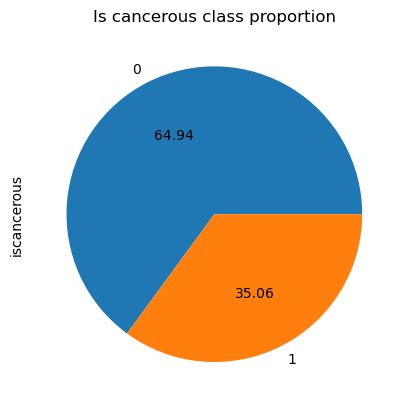

In [17]:
df_concat['iscancerous'].value_counts().plot(kind='pie', autopct ='%.2f')
plt.title('Is cancerous class proportion')

We notice that the data is imbalance between cancerous and non cancerous class, therefore we need to perform class balancing using sklearn.imblearn library

In [18]:
!pip install imbalanced-learn
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_concat, y_concat = ros.fit_resample(df_concat.drop('iscancerous',axis =1), df_concat['iscancerous'])


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 1.7 MB/s eta 0:00:00a 0:00:01


Text(0.5, 1.0, 'Is cancerous class proportion balanced')

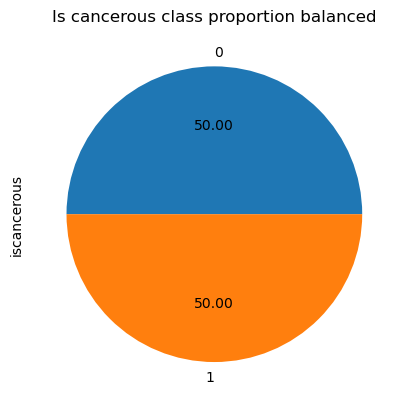

In [24]:
y_concat.value_counts().plot(kind='pie', autopct ='%.2f')
plt.title('Is cancerous class proportion balanced')

In [20]:
df_concat_balanced=pd.concat([X_concat,y_concat],axis=1)

Text(0.5, 1.0, 'Celltype class proportion')

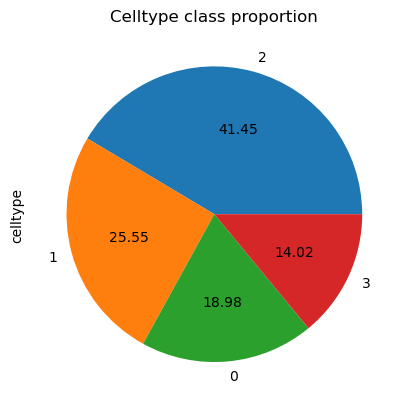

In [21]:
df_labels_dropped['celltype'].value_counts().plot(kind='pie', autopct ='%.2f')
plt.title('Celltype class proportion')

In [22]:
X_labels_balanced, y_labels_balanced = ros.fit_resample(df_labels_dropped.drop('celltype',axis =1), df_labels_dropped['celltype'])


Text(0.5, 1.0, 'Celltype class proportion balanced')

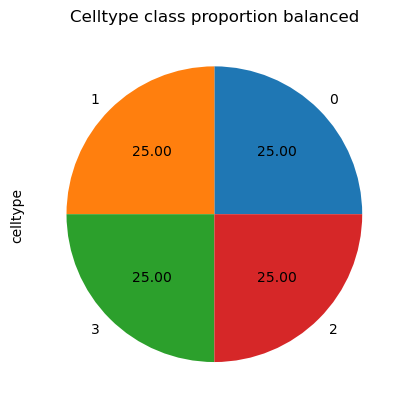

In [23]:
y_labels_balanced.value_counts().plot(kind='pie', autopct ='%.2f')
plt.title('Celltype class proportion balanced')

In [23]:
df_labels_balanced=pd.concat([X_labels_balanced,y_labels_balanced],axis=1)

### Convert image into a numpy array :
For classic machinelearning problem, we need to reshape the image into a numpy array and add to the original dataframe. The format images of the dataset have shape of 27x27 and 3 color channel (r,g and b) 

In [24]:
data_path = './patch_images'
def get_image(row):
    # Get the file path from the 'image_path' column of the row
    image_path = pathlib.Path(data_path).joinpath(row['imagename'])

    # Read the image file and convert it to a NumPy array
    image = imageio.imread(image_path)
    
    # Return the image array
    return image.ravel()

In [25]:
df_concat_balanced["image"] = df_concat_balanced.apply(get_image, axis=1)

/tmp/ipykernel_407/1237237695.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(image_path)


In [26]:
image_len = df_concat_balanced.loc[0]['image'].shape[0]

In [27]:
# splitting the array into separate columns
df_converted_np = pd.DataFrame(df_concat_balanced["image"].to_list(), columns=[f"p{n}" for n in range(image_len)])
df_converted_np = df_converted_np.astype(np.uint8)  # convert to 1 byte of unsigned int



In [28]:
# concatenate the original dataframe with the new columns
converted_df = pd.concat([df_concat_balanced[['iscancerous']].reset_index(drop=True), df_converted_np.reset_index(drop=True)], axis=1)
converted_df


,iscancerous,p0,p1,p2,p3,p4,p5,p6,p7,p8,...,p2177,p2178,p2179,p2180,p2181,p2182,p2183,p2184,p2185,p2186
0,0,164,124,180,146,108,169,172,134,199,...,222,163,115,188,160,113,185,168,122,191
1,0,241,236,240,242,234,239,240,229,237,...,158,151,107,179,138,91,175,101,54,142
2,0,250,240,252,254,244,255,239,228,246,...,230,243,216,237,239,209,231,246,213,238
3,0,255,237,255,243,224,242,238,222,233,...,187,202,118,163,183,97,147,200,114,167
4,0,222,198,219,230,204,227,218,186,215,...,245,244,212,229,241,204,226,235,195,221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26095,1,147,112,202,139,101,187,154,114,197,...,246,187,141,231,122,78,170,111,68,162
26096,1,255,244,255,248,232,255,222,202,246,...,181,163,133,201,182,151,225,156,124,202
26097,1,110,67,162,118,73,168,134,89,183,...,200,169,137,218,167,134,214,184,150,228
26098,1,136,88,180,155,106,198,159,110,202,...,226,185,128,201,196,138,208,224,167,243


In [30]:
›def spares_coverter(input_df, res_col='iscancerous'):
    input_df["image"] = input_df.apply(get_image, axis=1)
    image_len = input_df.loc[0]['image'].shape[0]
    df_converted_np = pd.DataFrame(input_df["image"].to_list(), columns=[f"p{n}" for n in range(image_len)])
    df_converted_np = df_converted_np.astype(np.uint8)  # convert to 1 byte of unsigned int
    res_df = pd.concat([input_df[[res_col]].reset_index(drop=True), df_converted_np.reset_index(drop=True)], axis=1)
    return res_df

In [29]:
# Export output as a CSV
converted_df.to_csv('./converted_data/converted_data.csv',index = False)
df_labels_balanced.to_csv('./converted_data/df_labels_balanced.csv', index = False)

In [31]:
df_labels_converted = spares_coverter(df_labels_balanced, 'celltype')

/tmp/ipykernel_407/1237237695.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(image_path)


In [33]:
df_labels_converted.to_csv('./converted_data/df_labels_balanced_converted.csv', index = False)

In [36]:
df_concat_balanced.to_csv('./converted_data/df_task1_balanced.csv', index = False)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=8d871b9e-4e37-4fce-a22e-8733be6e4afc' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>